# Characterizing Distributions of Generated Molecules

## Configuration

In [173]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print('Working directory:', cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
Working directory: /home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [174]:
import numpy as np
import pandas as pd

from rdkit import Chem
import useful_rdkit_utils as uru

import pickle

from molscore import MolScore
from moleval.metrics.metrics import GetMetrics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [175]:
#Seaborn settings for visualizations

rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)
pd.set_option('display.max_columns',35)
pd.options.display.float_format = '{:,.2f}'.format

In [176]:
# Set pandas display options to improve readability

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

In [177]:
fragments = []

f = open("data/fragments.smi", "r")

for i in range(1, 51):
    mol = f.readline()
    fragments.append(mol[:-1])

In [178]:
models = ['reinvent', 'crem', 'coati', 'safe']

## Generating Data

In [179]:
# %%capture

# reinvent_distributions, crem_distributions, coati_distributions, safe_distributions = [], [], [], []

# for fragment in fragments:
#     for model in models:

#         DF_FILEPATH = f'data/{model}_dataframe.csv'

#         arg1 = '--model'
#         arg2 = '--input_frag'
#         arg3 = '--sample'

#         args = ['python3', 'generate_analogs.py',
#                 arg1, model,
#                 arg2, fragment,
#                 arg3, '200']

#         # Change directory to generate analogs with python script
#         %cd ..

#         subprocess.run(args,
#                     stdout=subprocess.DEVNULL,
#                     stderr=subprocess.STDOUT)
                
#         # Change directory back to that of the current notebook
#         %cd experiments

#         df = pd.read_csv(DF_FILEPATH, index_col=0)

#         df['Model'] = model

#         if model == 'reinvent':
#             reinvent_distributions.append(df)
#         elif model == 'crem':
#             crem_distributions.append(df)
#         elif model == 'coati':
#             coati_distributions.append(df)
#         elif model == 'safe':
#             safe_distributions.append(df)

In [180]:
# data = {'reinvent' : reinvent_distributions,
#         'crem' : crem_distributions,
#         'coati' : coati_distributions,
#         'safe' : safe_distributions}

In [181]:
# with open('lists.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [182]:
with open('lists.pkl', 'rb') as file:
    data = pickle.load(file)

In [183]:
reinvent_distributions = data['reinvent']
crem_distributions = data['crem']
coati_distributions = data['coati']
safe_distributions = data['safe']

## Preprocessing

### Filtering Odd Rings

In [184]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

    odd_rings = df['min_freq'] < 100

    df['Odd rings'] = ~ odd_rings

    df = df[df['Odd rings']].drop(columns=['Odd rings'])
    
    return df.loc[:, ['SMILES', 'Model']]

In [185]:
'''
Removes distributions with zero molecules

Removes invalid SMILES strings

Removes odd ring systems from distributions
'''

for d in data:
    
    for i, df in enumerate(data[d]):

        if df.empty:
            data[d].pop(i)
        else:

            smiles_list = df['SMILES'].to_list()

            valid_smiles = []
            invalid_smiles = []

            for smiles in smiles_list:
                
                try:
                    molecule = Chem.MolFromSmiles(smiles, sanitize=True)
                    if molecule is not None:
                        valid_smiles.append(True)
                    else:
                        valid_smiles.append(False)
                except Exception as e:
                    invalid_smiles.append(smiles)

            df = remove_odd_rings(df)

            data[d][i] = df

        if df.empty:
            data[d].pop(i)

## Computing Distribution Metrics

In [186]:
metrics_df = pd.DataFrame()

In [187]:
%%capture

data['safe'].pop(8)
data['safe'].pop(7)

for d in data:
    
    for df in data[d]:
        
        smiles = df['SMILES'].to_list()

        MetricEngine = GetMetrics(
            n_jobs=1,
            device='cuda:0',
            batch_size=512,
            run_fcd=False
        )
        metrics = MetricEngine.calculate(
            smiles,
            calc_valid=True,
            calc_unique=True,
            unique_k=10000,
            se_k=1000,
            sp_k=1000,
            properties=True,
        )

        temp_df = pd.DataFrame(data=metrics, index=[0])

        temp_df['Model'] = d

        metrics_df = pd.concat((metrics_df, temp_df))

In [188]:
# for df in data['safe']:

#     smiles = df['SMILES'].to_list()

#     MetricEngine = GetMetrics(
#                 n_jobs=1,
#                 device='cuda:0',
#                 batch_size=512,
#                 run_fcd=False
#     )
#     metrics = MetricEngine.calculate(
#                 smiles,
#                 calc_valid=True,
#                 calc_unique=True,
#                 unique_k=10000,
#                 se_k=1000,
#                 sp_k=1000,
#                 properties=True,
#     )

In [189]:
# df = data['safe'][8]


# smiles = df['SMILES'].to_list()

# MetricEngine = GetMetrics(
#             n_jobs=1,
#             device='cuda:0',
#             batch_size=512,
#             run_fcd=False
# )
# metrics = MetricEngine.calculate(
#             smiles,
#             calc_valid=True,
#             calc_unique=True,
#             unique_k=10000,
#             se_k=1000,
#             sp_k=1000,
#             properties=True,
# )

In [190]:
# data['safe'].pop(7)

In [191]:
metrics_df

,#,Validity,# valid,Uniqueness,# valid & unique,IntDiv1,IntDiv2,SEDiv,SPDiv,# scaffolds,ScaffDiv,ScaffUniqueness,FG,RS,Filters,Purchasable_ZINC20,Model
0,102,1.00,102,0.93,95,0.79,0.75,0.27,0.91,39,0.74,0.41,0.08,0.31,0.49,0.32,reinvent
0,200,1.00,200,0.94,188,0.74,0.72,0.15,0.89,26,0.72,0.14,0.08,0.09,0.53,0.19,reinvent
0,199,1.00,199,0.94,188,0.77,0.74,0.19,0.90,17,0.59,0.09,0.09,0.05,0.59,0.44,reinvent
0,199,1.00,199,0.89,178,0.66,0.64,0.10,0.79,23,0.60,0.13,0.11,0.08,0.84,0.36,reinvent
0,200,1.00,200,0.96,192,0.73,0.71,0.16,0.88,22,0.62,0.11,0.09,0.03,0.57,0.40,reinvent
0,200,1.00,200,0.90,180,0.76,0.74,0.22,0.89,23,0.66,0.13,0.07,0.09,0.50,0.13,reinvent
0,198,1.00,198,0.92,182,0.69,0.67,0.15,0.78,21,0.62,0.12,0.08,0.05,0.78,0.14,reinvent
0,200,1.00,200,0.93,185,0.65,0.62,0.09,0.69,14,0.62,0.08,0.07,0.07,0.86,0.19,reinvent
0,186,1.00,186,0.94,175,0.75,0.73,0.23,0.89,36,0.71,0.21,0.09,0.14,0.66,0.31,reinvent
0,183,1.00,183,0.86,157,0.72,0.70,0.15,0.90,47,0.70,0.30,0.06,0.13,0.85,0.54,reinvent


## Exploratory Data Analysis

### Preliminary Statistics

In [192]:
metrics_df.head()

,#,Validity,# valid,Uniqueness,# valid & unique,IntDiv1,IntDiv2,SEDiv,SPDiv,# scaffolds,ScaffDiv,ScaffUniqueness,FG,RS,Filters,Purchasable_ZINC20,Model
0,102,1.00,102,0.93,95,0.79,0.75,0.27,0.91,39,0.74,0.41,0.08,0.31,0.49,0.32,reinvent
0,200,1.00,200,0.94,188,0.74,0.72,0.15,0.89,26,0.72,0.14,0.08,0.09,0.53,0.19,reinvent
0,199,1.00,199,0.94,188,0.77,0.74,0.19,0.90,17,0.59,0.09,0.09,0.05,0.59,0.44,reinvent
0,199,1.00,199,0.89,178,0.66,0.64,0.10,0.79,23,0.60,0.13,0.11,0.08,0.84,0.36,reinvent
0,200,1.00,200,0.96,192,0.73,0.71,0.16,0.88,22,0.62,0.11,0.09,0.03,0.57,0.40,reinvent


In [193]:
metrics_df[['Model', 'Uniqueness', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', 'ScaffDiv', 'FG', 'RS', 'Purchasable_ZINC20']].groupby("Model").mean()


,Uniqueness,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20
Model,,,,,,,,,
coati,1.00,0.65,0.63,0.22,0.88,0.69,0.19,0.16,0.09
crem,1.00,0.78,0.75,0.37,0.91,0.74,0.22,0.17,0.34
reinvent,0.92,0.67,0.65,0.11,0.78,0.63,0.08,0.07,0.22
safe,0.81,0.59,0.58,0.07,0.73,0.62,0.09,0.09,0.00


In [194]:
metrics_df[['Model', 'Uniqueness', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', 'ScaffDiv', 'FG', 'RS', 'Purchasable_ZINC20']].groupby("Model").std()

,Uniqueness,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20
Model,,,,,,,,,
coati,0.00,0.07,0.07,0.12,0.06,0.08,0.11,0.11,0.07
crem,0.00,0.09,0.09,0.24,0.11,0.09,0.06,0.10,0.17
reinvent,0.02,0.06,0.05,0.06,0.08,0.07,0.02,0.05,0.15
safe,0.19,0.08,0.07,0.06,0.11,0.08,0.04,0.04,0.00


It seems like the means and standard deviations vary pretty widely across the four models. For example, The standard average scaffold diversity of CReM and SAFE are .74 and .84, respectively. These are higher than those of REINVENT and COATI; .63 and .68, respectively. Interestingly, CReM has a very high standard deviation of scaffold diversity, 0.25. This suggests that the scaffold diversity for CReM is fairly sensitive to the input molecule. Another interesting thing to note is the high purchasability of CReM and REINVENT, whereas the average purchasability of SAFE is zero. This feels somewhat concerning.

### Missing Values

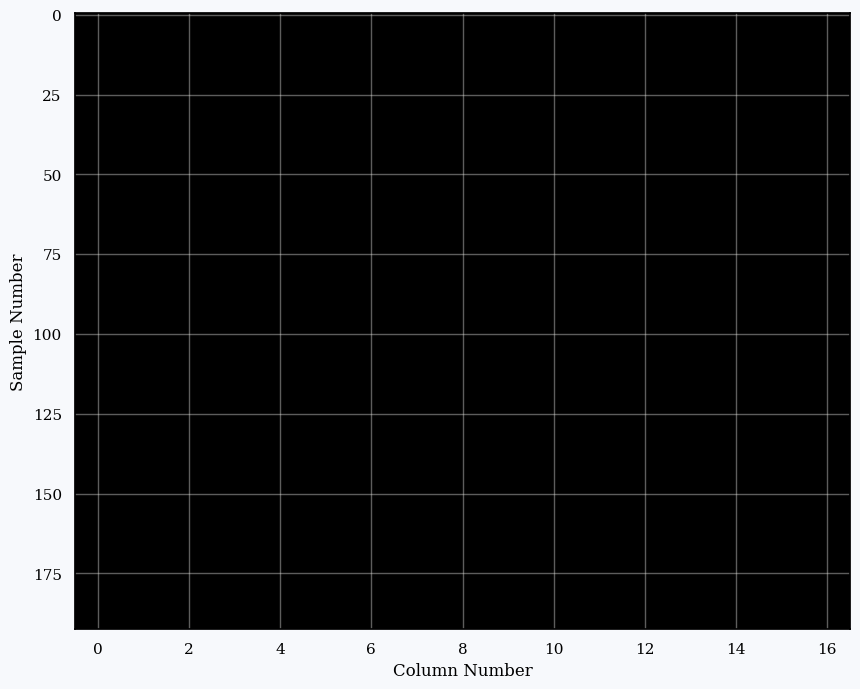

In [195]:
plt.figure(figsize=(10, 8))
plt.imshow(metrics_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

It seems like there are no missing values in the dataset.

### Visualizing the distributions (of distributions)

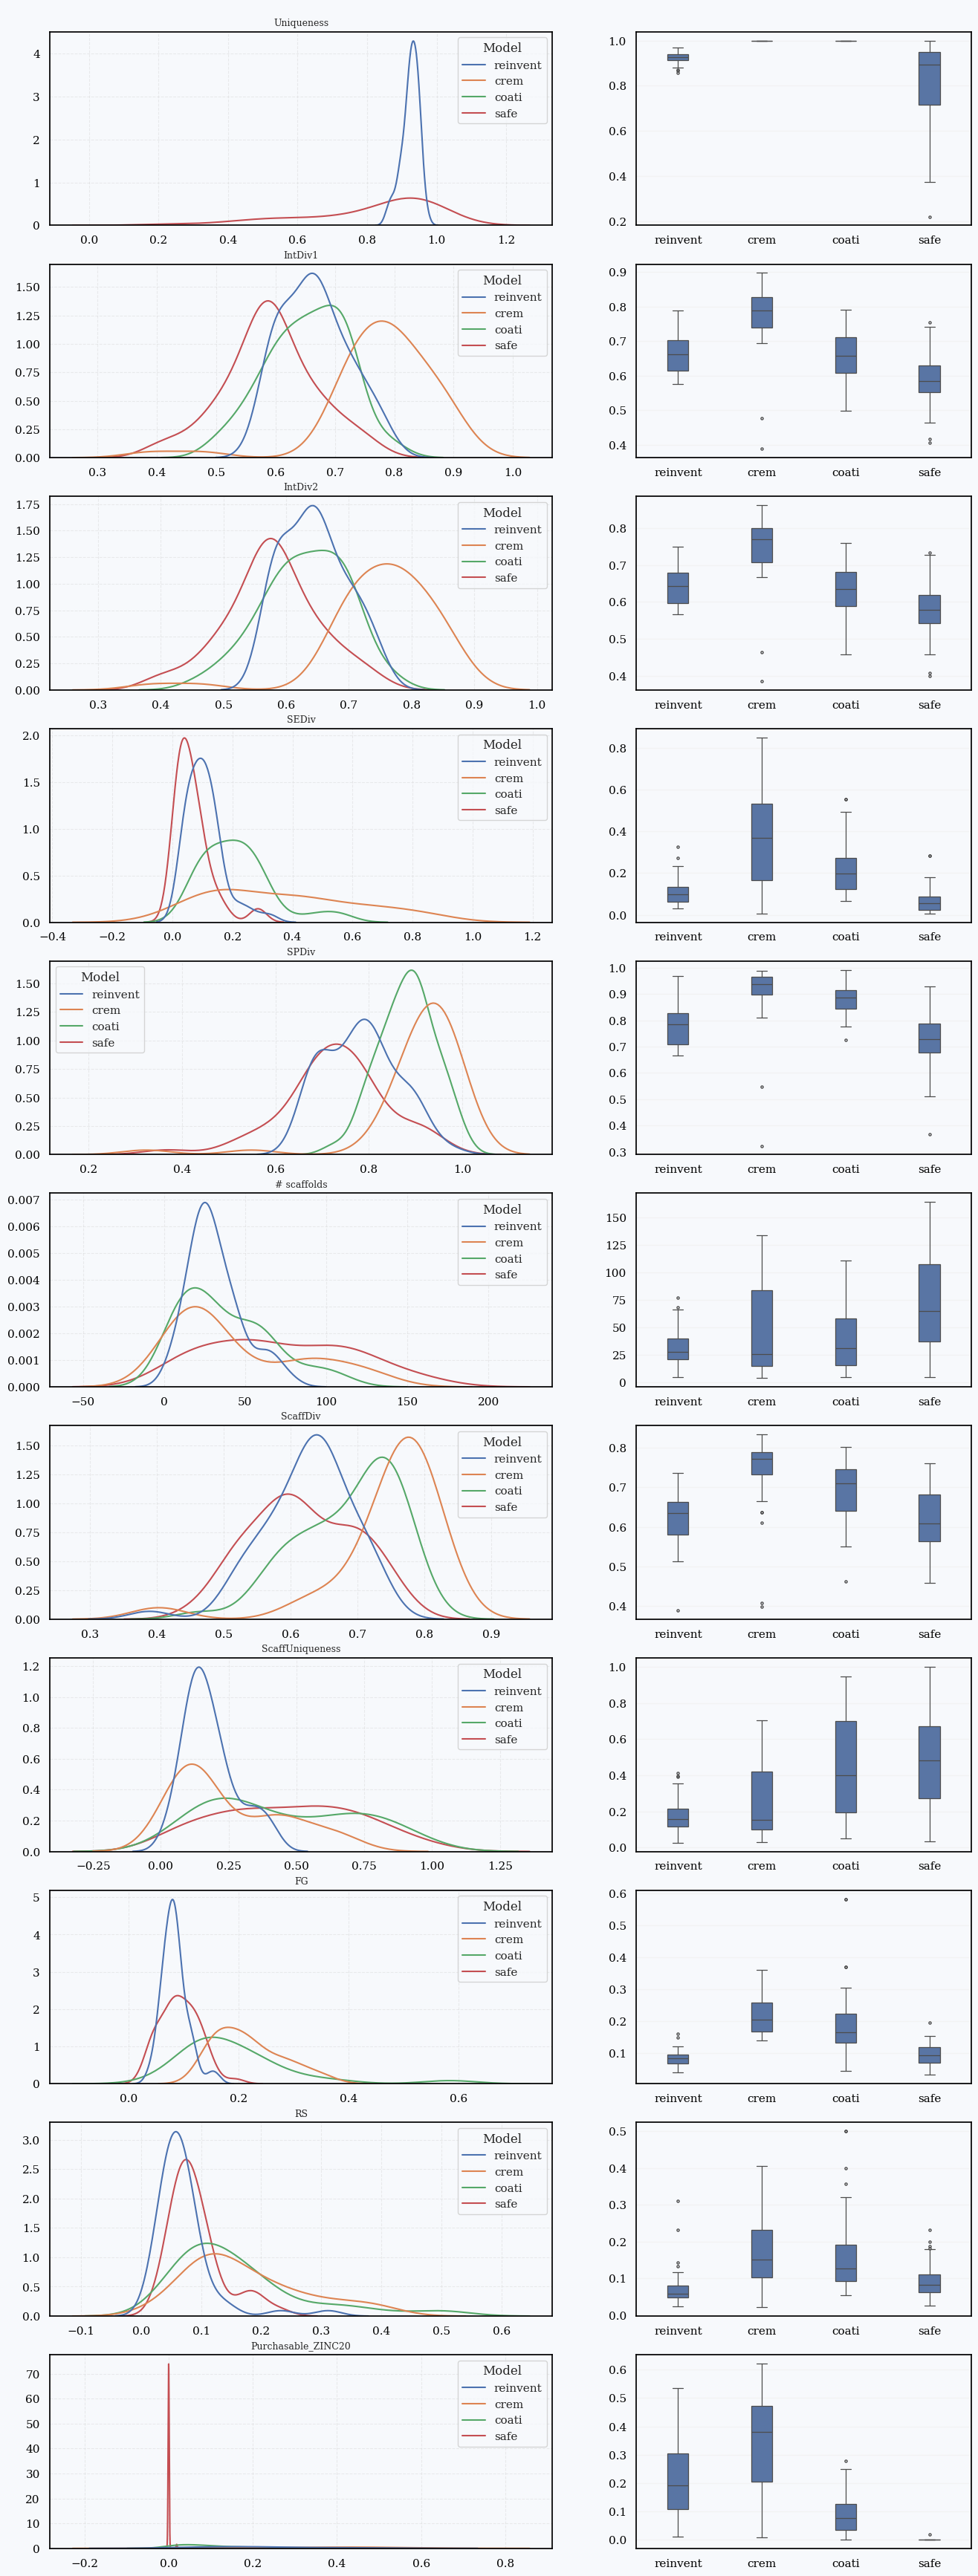

In [196]:
cols = ['Uniqueness', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', '# scaffolds', 'ScaffDiv', 'ScaffUniqueness', 'FG', 'RS', 'Purchasable_ZINC20']

fig, axs = plt.subplots(nrows=len(cols),
                        ncols=2,
                        figsize=(16, len(cols)*4),
                        gridspec_kw={'width_ratios' : [0.6, 0.4]})

for i, col in enumerate(cols):

    ax = axs[i, 0]

    sns.kdeplot(data=metrics_df[[col,'Model']],
                x=col,
                hue='Model',
                warn_singular=False,
                ax=ax)
    
    ax.set_title(f"\n{col}", fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')
    
    ax = axs[i, 1]

    sns.boxplot(data=metrics_df,
                x = 'Model',
                y=col,
                ax=ax,
                width=0.25,
                linewidth=0.90,
                fliersize=2.25)
    
    ax.set(xlabel = '', ylabel = '')

It seems like the models can be consistently differentiated. One thing that is interesting is the very small variance in the metrics for SAFE. This raises the question: does SAFE always generate the same molecules, irrespective of the input fragment? This will be something I explore later on.

### Assessing correlation

In [197]:
y = metrics_df['Model'].to_numpy().reshape(-1, 1)

In [198]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [199]:
X = metrics_df[cols]

X['Model'] = ord.squeeze()

In [200]:
# Computes feature correlation
corr = X.corr(method="pearson")

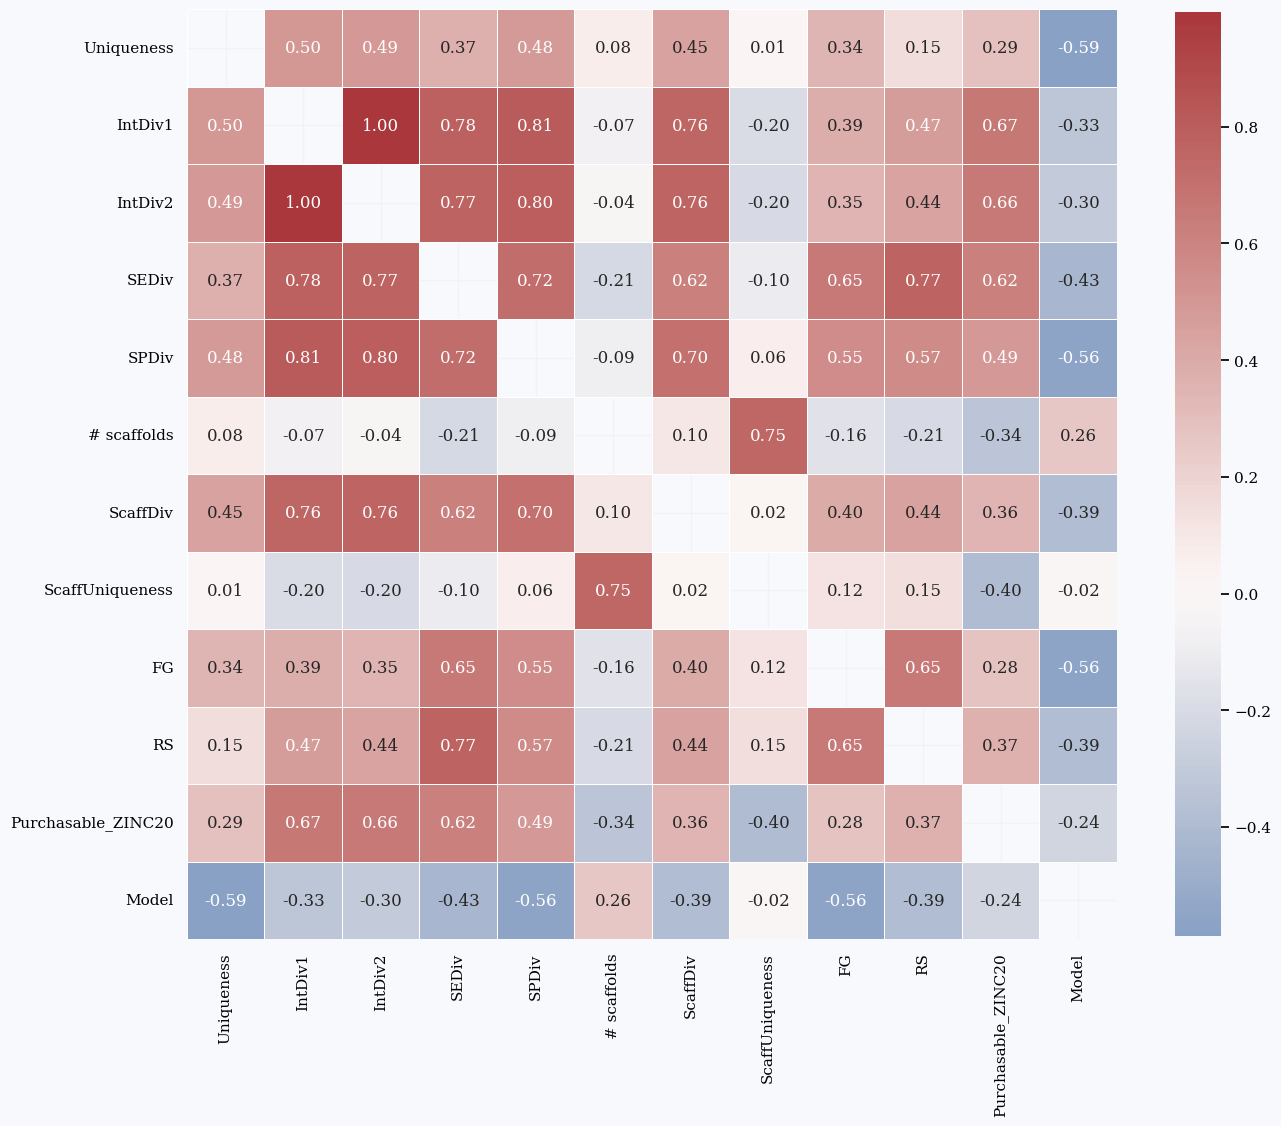

In [201]:
# Create labels for the correlation matrix
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=True, fmt='.2f', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

It's somewhat unsurprising that a lot of the variables are highly correlated, considering the fact that many of them measure similar quantities. However, it is interesting to note the high negative correlation between purchasability and scaffold uniqueness, as well as the high correlations between the model and SEDiv as well as # of scaffolds.

### Visualizing feature space

In [202]:
X.drop(['Model'], axis=1, inplace=True)

In [203]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

pca.explained_variance_ratio_

array([9.99885247e-01, 6.08552213e-05, 2.61296934e-05])

In [204]:
X['PC1'], X['PC2'], X['PC3'], X['Model'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2], metrics_df['Model']

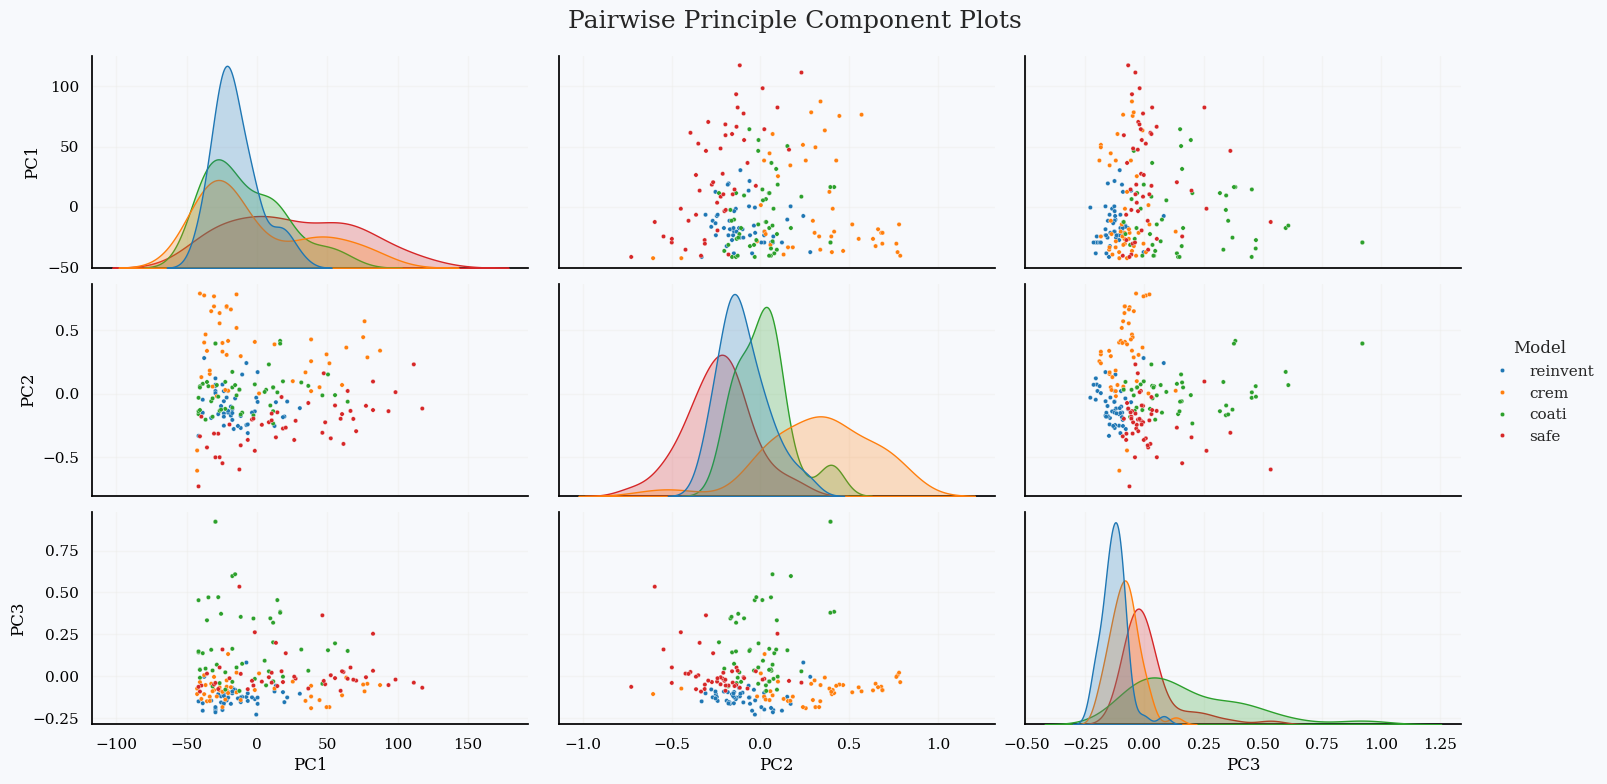

In [205]:
f = sns.pairplot(X,
                 hue='Model',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='tab10',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);

In [213]:
X.drop(['Model'], axis=1, inplace=True)

In [214]:
p = 50

pca_model = PCA(n_components=10, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [215]:
X['TSNE1'], X['TSNE2' ], X['Model'] = tsne_fps.T[0], tsne_fps.T[1], metrics_df['Model']

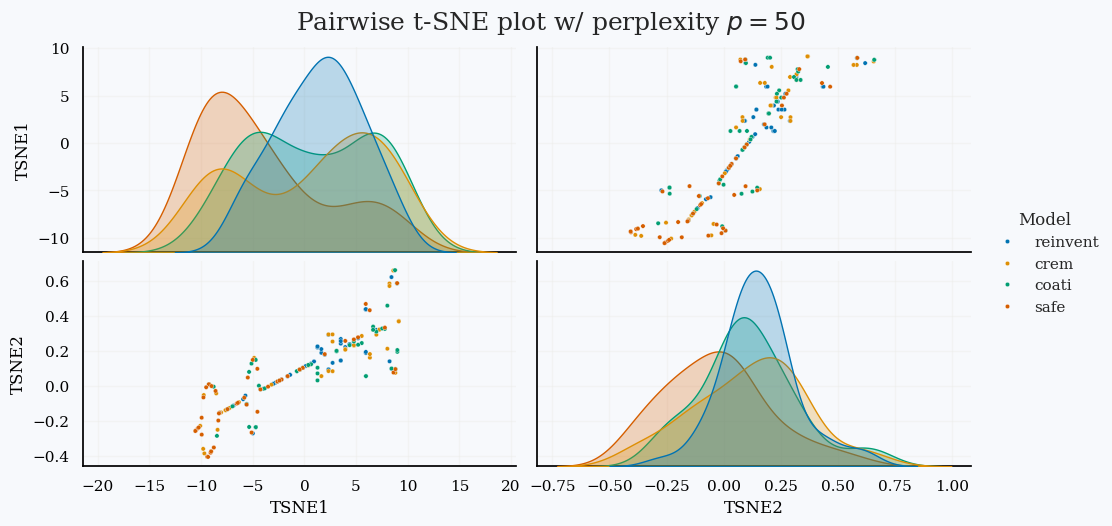

In [216]:
f = sns.pairplot(X,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);